Consider a smart power system,

Power dynamics of PV:
$$P_{PV}(t)=\hat{P}_{PV}(t)+P_{sun}(t)E_{PV}(t)$$
where, $\hat{P}_{PV}(t)=P_{sun}(t)r(t)$ is obtained via NN model and 
$$ dE_{PV}(t)=-\theta_{PV}(t)(E_{PV}(t)-\mu_{PV}(t))dt+\sigma_{PV} dW_{PV}(t)$$

Power dynamics of Load:
$$P_{Load}(t)=\hat{P}_{Load}(t)+E_{Load}(t)$$
where, $\hat{P}_{Load}(t)$ is obtained via NN model and 
$$ dE_{Load}(t)=-\theta_{Load}(t)(E_{Load}(t)-\mu_{Load}(t))dt+\sigma_{Load} dW_{Load}(t)$$

Power dynamics of controllable generators $G_i$:

$$P_{G_i}(t)=\Delta P_{G_i}(t)+P_{G_i}(t_0)$$
and
$$d\Delta P_{G_i}(t)=-\frac{1}{T_{G_i}}(\Delta P_{G_i}(t)-u_{G_i})dt$$

Dynamics of battery storage:
$$dSOC(t)=[\eta_{+}P_{BES}(t)\mathbb{I}(P_{BES}(t)>0)+\eta_{-}P_{BES}(t)\mathbb{I}(P_{BES}(t)<0)]dt$$
$$dDOD(t)=[\eta_{*}P_{BES}(t)\mathbb{I}(P_{BES}(t)>0)+\eta_{-}P_{BES}(t)\mathbb{I}(P_{BES}(t)<0)]dt$$
where,
$$
\begin{align}
P_{BES}(t)&=P_{PV}(t)-P_{Load}(t)+\sum_{i}{P_{G_i}(t)}\\
&=\hat{P}_{PV}(t)+P_{sun}(t)E_{PV}(t)-\hat{P}_{Load}(t)-E_{Load}(t)+\sum_{i}{(\Delta P_{G_i}(t)+P_{G_i}(t_0))}
\end{align}
$$
The $\eta_{*}$ for $DOD$ should be properly chosen such that when $P_{BES}(t)<0$, i.e., end of a discharging process, $DOD$ decreases to zero quickly.

Three main performance indexes are concerned in this paper,
i) the operational cost of generators:
$$cost_{G}=\int_0^T{[\sum_{i}{a_i+b_iP_{G_i}(t)+c_iP_{G_i}^2(t)}]dt}$$
ii) the rational utilization of batteries:

The battery life time is modeled with the PLET model, which means that the total cycle $N$ of the battery under given depth of discharge $DOD$ satisfies $Nd^{\alpha}=C$. Thus, consider a discharging process with $DOD=d$ in $t\in [0,\tau]$, the total loss of health (LoH) of the batteries is $LoH=d^{\alpha}/C$, which could be expressed as 
$$LoH=\int_0^\tau{\frac{1}{C}\frac{\partial DOD^{\alpha}}{\partial DOD} dDOD}$$
In this sense, by minimizing the LoH of BESs, the lifetime of these devices could be expanded
$$cost_{BES}=\int_0^T{\frac{\alpha}{C}DOD^{\alpha-1}\mathbb{I}(P_{BES}(t)<0)dDOD}$$
iii) regularization for a rational control scheme:
$$cost_{U}=\int_0^T{u_G^2 dt}$$

The three performance indexes are considered simultaneously in the objective functional:
$$J(x,t)=inf_{u\in U} {[\xi_G cost_G+\xi_{BES} cost_{BES} +\xi_u cost_U]}$$

with the system dynamics as the constraint:
$$dx=(F(x,t)+Bu)dt+D(t)dW(t)$$ and $x(0)=x_0$

where, $x=[E_{PV}(t),E_{Load}(t),P_{G_1}(t),P_{G_2}(t),\ldots,P_{G_n}(t),SOC(t),DOD(t)]'$, $u=[u_{G_1},u_{G_2},\ldots,u_{G_n}]'$ and $W(t)=[W_{PV}(t),W{Load}(t)]'$

In [2]:
from datetime import datetime, timedelta
from dateutil import tz
import pandas as pd
import numpy as np


from matplotlib import pyplot as plt
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
%config InlineBackend.figure_format='svg'
%matplotlib inline

In [3]:
str2time= lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S%z')
time2str=lambda time:time.strftime('%Y-%m-%d %H:%M:%S%z')

def time2str_fix(time):
    string=time2str(time)
    return string[:-2]+':'+string[-2:]

In [63]:
# power data with residual parameters estimated with MAP based on real data
load_data=pd.read_hdf('power_model_with_parameter_estimation.h5',key='load',mode='r')
pv_data=pd.read_hdf('power_model_with_parameter_estimation.h5',key='pv',mode='r')

In [26]:
load_data.head()

,time,load_raw,load_est,theta,sigma
0,2016-01-01 04:30:00-06:00,236.422,263.795690,1.178554,52.218461
1,2016-01-01 04:31:00-06:00,234.123,263.798104,1.178554,52.218461
2,2016-01-01 04:32:00-06:00,239.431,263.805345,1.178554,52.218461
3,2016-01-01 04:33:00-06:00,240.633,263.817415,1.178554,52.218461
4,2016-01-01 04:34:00-06:00,241.896,263.834311,1.178554,52.218461


In [27]:
results=load_data['load_raw'].shift(-1)-load_data['load_raw']

In [28]:
import seaborn
seaborn.set_context('paper', font_scale=1.5)
import scipy.stats as stats
from sklearn import mixture

In [29]:
h=2*(results.quantile(0.75)-results.quantile(0.25))*np.power(results.size,-1/3)
(results.max()-results.min())/h

898.2345745940886

In [30]:
results=results[~results.isna()]

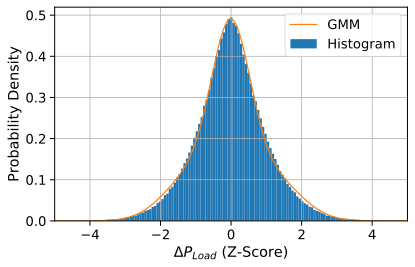

In [31]:
results=(results-results.mean())/results.std()
_=plt.hist(results,bins=378,density=True,label='Histogram')

clf = mixture.GaussianMixture(n_components=3, covariance_type='full')

clf.fit(results.values[:,np.newaxis])

x = np.linspace(-5,5, 400)
y=np.zeros_like(x)
for i in range(3):
    y+=clf.weights_[i]*stats.norm.pdf(x, clf.means_[i], np.sqrt(clf.covariances_[i][0,0]))
plt.plot(x, y, label='GMM')
plt.xlim([-5,5])
plt.legend()
plt.xlabel('$\Delta P_{Load}$ (Z-Score)')
plt.ylabel('Probability Density')
plt.grid()
plt.tight_layout()
plt.savefig('../sde_nn_power_model/figures/LoadIncrementGMM3comp.svg')

In [32]:
pv_data.head()

,time,pv_raw,pv_est,p_sun,theta,sigma
0,2016-01-01 04:30:00-06:00,-0.989,0.0,0.0,18.616366,0.001805
1,2016-01-01 04:31:00-06:00,-0.975,0.0,0.0,18.616366,0.001805
2,2016-01-01 04:32:00-06:00,-0.973,0.0,0.0,18.616366,0.001805
3,2016-01-01 04:33:00-06:00,-0.964,0.0,0.0,18.616366,0.001805
4,2016-01-01 04:34:00-06:00,-0.960,0.0,0.0,18.616366,0.001805


In [33]:
results=(pv_data['pv_raw'][1:].values-pv_data['pv_raw'][:-1].values)/pv_data['p_sun'][:-1]
results=results[~np.isinf(results)]
results=results[~np.isnan(results)]
print(results.size)
results=results[results<1]
results=results[results>-1]
print(results.size)


278335
278146


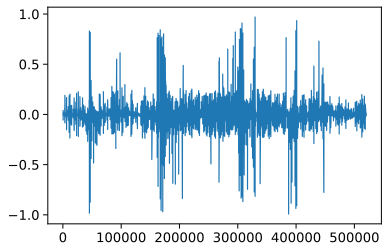

In [34]:
plt.plot(results)

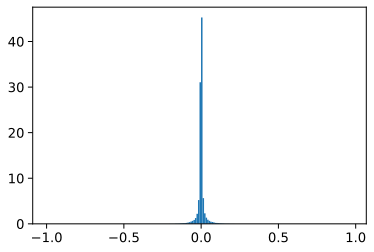

In [35]:
_=plt.hist(results,bins=200,density=True)

In [36]:
h=2*(results.quantile(0.75)-results.quantile(0.25))*np.power(results.size,-1/3)
(results.max()-results.min())/h

8483.51218166185

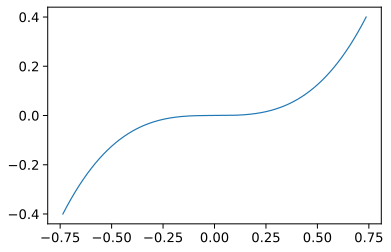

In [37]:
input=np.linspace(-np.power(0.4,1/3),np.power(0.4,1/3),300)
plt.plot(input,np.power(input,3))
bins=np.concatenate([[-1],np.power(input,3),[1]])

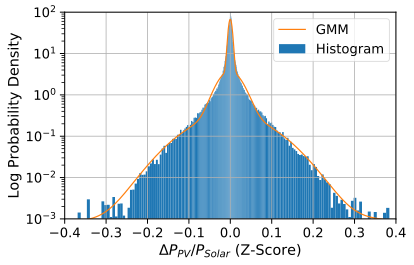

In [53]:
from sklearn import mixture

_=plt.hist(results,bins=bins,density=True,label='Histogram')
clf = mixture.GaussianMixture(n_components=5, covariance_type='full')
clf.fit(results[:,np.newaxis])
x = bins
y=np.zeros_like(x)
for i in range(5):
    y+=clf.weights_[i]*stats.norm.pdf(x, clf.means_[i], np.sqrt(clf.covariances_[i][0,0]))
plt.semilogy(x, y,label='GMM')
plt.ylim([1e-3,100])
plt.xlim([-0.4,0.4])
plt.legend()
plt.xlabel('$\Delta P_{PV}/P_{Solar}$ (Z-Score)')
plt.ylabel('Log Probability Density')
plt.grid()
plt.tight_layout()
plt.savefig('../sde_nn_power_model/figures/PVIncrementGMM5comp.svg')

In [51]:
clf.means_[0]*clf.weights_

array([-6.50585593e-05, -1.08863466e-05, -6.05262678e-06, -9.37386067e-06,
       -1.30295851e-07])

Get data for training and simulation

In [4]:
load_data=pd.read_hdf('weatherdataset_with_parameter.h5',key='load',mode='r')
pv_data=pd.read_hdf('weatherdataset_with_parameter.h5',key='pv',mode='r')

In [5]:
load_data.head()

,time,summary,temperature,humidity,pressure,wind_speed,cloud_cover,precip_probability,theta,mu,sigma
0,2016-01-01 00:00:00-06:00,Overcast,47.22,0.71,1028.73,8.09,0.96,0.00,8.417047,-2.159399,41.987996
1,2016-01-01 01:00:00-06:00,Overcast,46.50,0.72,1028.79,8.22,1.00,0.00,4.735537,-16.488691,37.394916
2,2016-01-01 02:00:00-06:00,Overcast,46.04,0.73,1028.84,8.74,1.00,0.00,3.580401,0.309037,36.294091
3,2016-01-01 03:00:00-06:00,Overcast,45.34,0.73,1028.68,9.31,1.00,0.00,7.669121,14.426460,38.354990
4,2016-01-01 04:00:00-06:00,Overcast,44.49,0.74,1029.27,8.84,1.00,0.11,8.067115,9.530105,37.087648


In [70]:
start=str2time('2016-04-12 00:00:00-05:00')
for i in range(30):
    s=start+timedelta(days=5*i)
    e=start+timedelta(days=5*i+1)
    oneday_loaddata=load_data[(load_data['time']>=time2str(s))&(load_data['time']<time2str(e))][['load_est','theta','sigma']]
    oneday_pvdata=pv_data[(pv_data['time']>=time2str(s))&(pv_data['time']<time2str(e))][['pv_est','p_sun','theta','sigma']]
    np.savez_compressed('./A2C_improve_nolstm/PV_%s'%i,oneday_pvdata.values)
    np.savez_compressed('./A2C_improve_nolstm/Load_%s'%i,oneday_loaddata.values)

In [71]:
load_data.head()

,time,load_raw,load_est,theta,sigma
0,2016-01-01 04:30:00-06:00,236.422,263.795690,1.178554,52.218461
1,2016-01-01 04:31:00-06:00,234.123,263.798104,1.178554,52.218461
2,2016-01-01 04:32:00-06:00,239.431,263.805345,1.178554,52.218461
3,2016-01-01 04:33:00-06:00,240.633,263.817415,1.178554,52.218461
4,2016-01-01 04:34:00-06:00,241.896,263.834311,1.178554,52.218461


In [79]:
start=str2time('2016-08-14 00:00:00-05:00')
i=0
for _ in range(1):
    s=start+timedelta(days=2*i)
    e=start+timedelta(days=2*i+1)
    oneday_loaddata=load_data[(load_data['time']>=time2str(s))&(load_data['time']<time2str(e))][['load_est','theta','sigma']]
    oneday_pvdata=pv_data[(pv_data['time']>=time2str(s))&(pv_data['time']<time2str(e))][['pv_est','p_sun','theta','sigma']]
    if len(oneday_loaddata)!=1440 or len(oneday_pvdata)!=1440:
        continue
    savedir='../BocopHJB-1.1.0-Linux/examples/default/parameters'
    np.savetxt(savedir+'/P_Load.txt',oneday_loaddata['load_est'])
    np.savetxt(savedir+'/theta_Load.txt',oneday_loaddata['theta'])
    np.savetxt(savedir+'/sigma_Load.txt',oneday_loaddata['sigma'])
    np.savetxt(savedir+'/P_PV.txt',oneday_pvdata['pv_est'])
    np.savetxt(savedir+'/P_Solar.txt',oneday_pvdata['p_sun'])
    np.savetxt(savedir+'/theta_PV.txt',oneday_pvdata['theta'])
    np.savetxt(savedir+'/sigma_PV.txt',oneday_pvdata['sigma'])
    i+=1

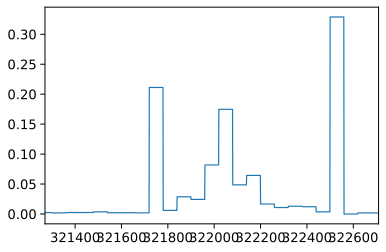

In [84]:
oneday_pvdata['sigma'].plot()